In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
# from torchsummary import summary

# from pushover import notify
# from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display
from PIL import Image as I

from imgaug import augmenters as iaa
from torchsummary import summary

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bs = 8

In [3]:
def augmentation(im):
    """
    image: 1, 3, n, n tensor
    
    output: num, 3, n, n tensor
    """
    transformations = [
        iaa.Crop(px=(0, 10)), # crop images from each side by 0 to 16px (randomly chosen)
        iaa.Fliplr(0.5), # horizontally flip 50% of the images
        iaa.GaussianBlur(sigma=(0, 3.0)), # blur images with a sigma of 0 to 3.0
        iaa.Noop()
    ]

    im = im.permute(1, 2, 0).numpy()
    return torch.Tensor([t(image=im) for t in transformations]).permute(0, 3, 1, 2)

In [5]:
# dataset = datasets.ImageFolder(root='./data-nodules2d', transform = transforms.Compose([transforms.ToTensor()]))
dataset = datasets.CIFAR10('.', transform = transforms.Compose([transforms.ToTensor(), augmentation]), download = True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
len(dataset.train_data), len(dataloader)

Files already downloaded and verified


(50000, 6250)

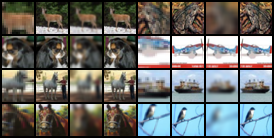

In [6]:
fixed_x, _ = next(iter(dataloader))
fixed_x = fixed_x.view(-1, 3, 32, 32)
save_image(fixed_x, 'real_image.png')
display(Image('real_image.png', width=1000, unconfined=True))

In [8]:
na = 4

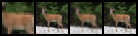

In [9]:
a = fixed_x.view(bs, na, 3, 32, 32)

save_image(a[0], 'real_image.png')
display(Image('real_image.png', width=500, unconfined=True))

### Todo: Totensor --> Numpy --> Totensor

In [21]:
x.view(1, 1, 4)

torch.Size([1, 1, 4])

In [44]:
x = torch.Tensor([1, 1, 1, 1]).view(1, 1, 4)

a = nn.MultiheadAttention(4, 1)
a(x, x, x)[0]

tensor([[[ 0.1450, -0.3249,  0.1780, -0.0398]]], grad_fn=<AddBackward0>)

In [53]:
class Net(nn.Module):
    def __init__(self, na=4):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 512)
        
        self.conv4 = nn.Conv2d(32, 16, 3,padding = 1)
        self.conv5 = nn.Conv2d(16, 6, 3,padding = 1)
        self.conv6 = nn.Conv2d(6, 3, 3,padding = 1)
        
        self.selfattn = nn.MultiheadAttention(128, 1)
        
        self.na = na

        
    def encoder(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 32 * 4 * 4)
        x = F.relu(self.fc1(x))
        return x
    
    
    # TODO: Use Fc for pooling    
    def pooling(self, vectors):
        na = self.na
        if not na:
            return vectors
        
        vectors = vectors.view(bs, na, 128)
        vectors = vectors[:, :na-1, :]
        vectors = vectors.permute(1, 0, 2)
        vectors, _ = self.selfattn(vectors, vectors, vectors)
        return vectors.mean(dim=0)
    
    def decoder(self, vector):
        x = self.fc2(vector)
        # 1, 512 --> 1, 32, 4, 4
        x = x.reshape(-1, 32, 4, 4)
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = self.conv4(x)
        x = F.relu(x)
        
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = self.conv5(x)
        x = F.relu(x)

        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = self.conv6(x)

        x = torch.sigmoid(x)
        return x
       
        
    def forward(self, x):
        x = x.view(-1, 3, 32, 32)
        x = self.encoder(x)
        x = self.pooling(x)
        y = self.decoder(x)
        return x, y

In [55]:
# summary(net, (3, 32, 32))

In [62]:
model = Net()
model.to(device)
optimizer = optim.Adam(model.parameters())
loss = nn.MSELoss()

In [69]:
model

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=512, bias=True)
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(16, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(6, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (selfattn): MultiheadAttention(
    (out_proj): Linear(in_features=128, out_features=128, bias=True)
  )
)

In [63]:
model.na = 4

In [64]:
for param in model.parameters():
    param.requires_grad = True

In [65]:
def train(train_loader, epochs=10):
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            
            optimizer.zero_grad()
            _, I_prime = model(data)

            I = data[:, -1, :]
            l1 = loss(I, I_prime)
            l1.backward()
            optimizer.step()

            if batch_idx % 2 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), l1.item()))

In [66]:
train(dataloader)

/Users/shubhamchandel/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Train Epoch: 0 [0/50000 (0%)]	Loss: 0.070050
Train Epoch: 0 [16/50000 (0%)]	Loss: 0.083062
Train Epoch: 0 [32/50000 (0%)]	Loss: 0.068441
Train Epoch: 0 [48/50000 (0%)]	Loss: 0.063597
Train Epoch: 0 [64/50000 (0%)]	Loss: 0.067981
Train Epoch: 0 [80/50000 (0%)]	Loss: 0.074912
Train Epoch: 0 [96/50000 (0%)]	Loss: 0.057400
Train Epoch: 0 [112/50000 (0%)]	Loss: 0.068373
Train Epoch: 0 [128/50000 (0%)]	Loss: 0.068491
Train Epoch: 0 [144/50000 (0%)]	Loss: 0.061220
Train Epoch: 0 [160/50000 (0%)]	Loss: 0.064272
Train Epoch: 0 [176/50000 (0%)]	Loss: 0.055403
Train Epoch: 0 [192/50000 (0%)]	Loss: 0.060562
Train Epoch: 0 [208/50000 (0%)]	Loss: 0.041433
Train Epoch: 0 [224/50000 (0%)]	Loss: 0.065434
Train Epoch: 0 [240/50000 (0%)]	Loss: 0.071381
Train Epoch: 0 [256/50000 (1%)]	Loss: 0.073399
Train Epoch: 0 [272/50000 (1%)]	Loss: 0.065296
Train Epoch: 0 [288/50000 (1%)]	Loss: 0.043488
Train Epoch: 0 [304/50000 (1%)]	Loss: 0.071100
Train Epoch: 0 [320/50000 (1%)]	Loss: 0.053530
Train Epoch: 0 [336/5

Train Epoch: 0 [2784/50000 (6%)]	Loss: 0.035746
Train Epoch: 0 [2800/50000 (6%)]	Loss: 0.031351
Train Epoch: 0 [2816/50000 (6%)]	Loss: 0.041164
Train Epoch: 0 [2832/50000 (6%)]	Loss: 0.034896
Train Epoch: 0 [2848/50000 (6%)]	Loss: 0.023867
Train Epoch: 0 [2864/50000 (6%)]	Loss: 0.034004
Train Epoch: 0 [2880/50000 (6%)]	Loss: 0.033795
Train Epoch: 0 [2896/50000 (6%)]	Loss: 0.038433
Train Epoch: 0 [2912/50000 (6%)]	Loss: 0.027898
Train Epoch: 0 [2928/50000 (6%)]	Loss: 0.039997
Train Epoch: 0 [2944/50000 (6%)]	Loss: 0.038236
Train Epoch: 0 [2960/50000 (6%)]	Loss: 0.029543
Train Epoch: 0 [2976/50000 (6%)]	Loss: 0.030793
Train Epoch: 0 [2992/50000 (6%)]	Loss: 0.032700
Train Epoch: 0 [3008/50000 (6%)]	Loss: 0.021041
Train Epoch: 0 [3024/50000 (6%)]	Loss: 0.037434
Train Epoch: 0 [3040/50000 (6%)]	Loss: 0.032435
Train Epoch: 0 [3056/50000 (6%)]	Loss: 0.033807
Train Epoch: 0 [3072/50000 (6%)]	Loss: 0.029379
Train Epoch: 0 [3088/50000 (6%)]	Loss: 0.034287
Train Epoch: 0 [3104/50000 (6%)]	Loss: 0

Train Epoch: 0 [5504/50000 (11%)]	Loss: 0.028763
Train Epoch: 0 [5520/50000 (11%)]	Loss: 0.030074
Train Epoch: 0 [5536/50000 (11%)]	Loss: 0.032660
Train Epoch: 0 [5552/50000 (11%)]	Loss: 0.026665
Train Epoch: 0 [5568/50000 (11%)]	Loss: 0.027551
Train Epoch: 0 [5584/50000 (11%)]	Loss: 0.048704
Train Epoch: 0 [5600/50000 (11%)]	Loss: 0.028052
Train Epoch: 0 [5616/50000 (11%)]	Loss: 0.027776
Train Epoch: 0 [5632/50000 (11%)]	Loss: 0.027975
Train Epoch: 0 [5648/50000 (11%)]	Loss: 0.022208
Train Epoch: 0 [5664/50000 (11%)]	Loss: 0.031102
Train Epoch: 0 [5680/50000 (11%)]	Loss: 0.030544
Train Epoch: 0 [5696/50000 (11%)]	Loss: 0.026443
Train Epoch: 0 [5712/50000 (11%)]	Loss: 0.026069
Train Epoch: 0 [5728/50000 (11%)]	Loss: 0.046684
Train Epoch: 0 [5744/50000 (11%)]	Loss: 0.029120
Train Epoch: 0 [5760/50000 (12%)]	Loss: 0.030828
Train Epoch: 0 [5776/50000 (12%)]	Loss: 0.039056
Train Epoch: 0 [5792/50000 (12%)]	Loss: 0.029307
Train Epoch: 0 [5808/50000 (12%)]	Loss: 0.029235
Train Epoch: 0 [5824

Train Epoch: 0 [8192/50000 (16%)]	Loss: 0.027177
Train Epoch: 0 [8208/50000 (16%)]	Loss: 0.027641
Train Epoch: 0 [8224/50000 (16%)]	Loss: 0.024511
Train Epoch: 0 [8240/50000 (16%)]	Loss: 0.032541
Train Epoch: 0 [8256/50000 (17%)]	Loss: 0.031211
Train Epoch: 0 [8272/50000 (17%)]	Loss: 0.021062
Train Epoch: 0 [8288/50000 (17%)]	Loss: 0.030094
Train Epoch: 0 [8304/50000 (17%)]	Loss: 0.023569
Train Epoch: 0 [8320/50000 (17%)]	Loss: 0.027957
Train Epoch: 0 [8336/50000 (17%)]	Loss: 0.026972
Train Epoch: 0 [8352/50000 (17%)]	Loss: 0.037240
Train Epoch: 0 [8368/50000 (17%)]	Loss: 0.025463
Train Epoch: 0 [8384/50000 (17%)]	Loss: 0.029632
Train Epoch: 0 [8400/50000 (17%)]	Loss: 0.029037
Train Epoch: 0 [8416/50000 (17%)]	Loss: 0.021350
Train Epoch: 0 [8432/50000 (17%)]	Loss: 0.029749
Train Epoch: 0 [8448/50000 (17%)]	Loss: 0.030286
Train Epoch: 0 [8464/50000 (17%)]	Loss: 0.019264
Train Epoch: 0 [8480/50000 (17%)]	Loss: 0.033588
Train Epoch: 0 [8496/50000 (17%)]	Loss: 0.033859
Train Epoch: 0 [8512

Train Epoch: 0 [10880/50000 (22%)]	Loss: 0.029986
Train Epoch: 0 [10896/50000 (22%)]	Loss: 0.025660
Train Epoch: 0 [10912/50000 (22%)]	Loss: 0.034003
Train Epoch: 0 [10928/50000 (22%)]	Loss: 0.031775
Train Epoch: 0 [10944/50000 (22%)]	Loss: 0.028900
Train Epoch: 0 [10960/50000 (22%)]	Loss: 0.028381
Train Epoch: 0 [10976/50000 (22%)]	Loss: 0.025652
Train Epoch: 0 [10992/50000 (22%)]	Loss: 0.020871
Train Epoch: 0 [11008/50000 (22%)]	Loss: 0.032487
Train Epoch: 0 [11024/50000 (22%)]	Loss: 0.028271
Train Epoch: 0 [11040/50000 (22%)]	Loss: 0.025460
Train Epoch: 0 [11056/50000 (22%)]	Loss: 0.025452
Train Epoch: 0 [11072/50000 (22%)]	Loss: 0.021530
Train Epoch: 0 [11088/50000 (22%)]	Loss: 0.029735
Train Epoch: 0 [11104/50000 (22%)]	Loss: 0.022449
Train Epoch: 0 [11120/50000 (22%)]	Loss: 0.027990
Train Epoch: 0 [11136/50000 (22%)]	Loss: 0.022775
Train Epoch: 0 [11152/50000 (22%)]	Loss: 0.026755
Train Epoch: 0 [11168/50000 (22%)]	Loss: 0.030345
Train Epoch: 0 [11184/50000 (22%)]	Loss: 0.017861


Train Epoch: 0 [13504/50000 (27%)]	Loss: 0.030871
Train Epoch: 0 [13520/50000 (27%)]	Loss: 0.028238
Train Epoch: 0 [13536/50000 (27%)]	Loss: 0.026139
Train Epoch: 0 [13552/50000 (27%)]	Loss: 0.041054
Train Epoch: 0 [13568/50000 (27%)]	Loss: 0.025962
Train Epoch: 0 [13584/50000 (27%)]	Loss: 0.036781
Train Epoch: 0 [13600/50000 (27%)]	Loss: 0.030852
Train Epoch: 0 [13616/50000 (27%)]	Loss: 0.026517
Train Epoch: 0 [13632/50000 (27%)]	Loss: 0.020882
Train Epoch: 0 [13648/50000 (27%)]	Loss: 0.026270
Train Epoch: 0 [13664/50000 (27%)]	Loss: 0.025609
Train Epoch: 0 [13680/50000 (27%)]	Loss: 0.027113
Train Epoch: 0 [13696/50000 (27%)]	Loss: 0.021533
Train Epoch: 0 [13712/50000 (27%)]	Loss: 0.023876
Train Epoch: 0 [13728/50000 (27%)]	Loss: 0.025195
Train Epoch: 0 [13744/50000 (27%)]	Loss: 0.025927
Train Epoch: 0 [13760/50000 (28%)]	Loss: 0.032711
Train Epoch: 0 [13776/50000 (28%)]	Loss: 0.029989
Train Epoch: 0 [13792/50000 (28%)]	Loss: 0.034607
Train Epoch: 0 [13808/50000 (28%)]	Loss: 0.023011


KeyboardInterrupt: 

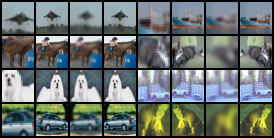

In [67]:
fixed_x, _ = next(iter(dataloader))
fixed_x = fixed_x.view(-1, 3, 32, 32)
save_image(fixed_x, 'real_image.png')
display(Image('real_image.png', width=1000, unconfined=True))

/Users/shubhamchandel/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


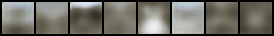

In [68]:
_, im = model(fixed_x)
save_image(im, 'real_image.png')
display(Image('real_image.png', width=1000, unconfined=True))

In [366]:
for param in model.parameters():
    param.requires_grad = False

### Evaluation starts here

In [367]:
class Evaluate(nn.Module):
    def __init__(self):
        super(Evaluate, self).__init__()
        self.fc1 = nn.Linear(128, 10)
    
    def forward(self,vector):
        x = self.fc1(vector)
        return x

In [368]:
net = Evaluate()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

net

Evaluate(
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)

### Dataloader

In [369]:
trainset = torchvision.datasets.CIFAR10(root='.',transform = transforms.Compose([transforms.ToTensor()]),
                                        train=True,download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

Files already downloaded and verified


In [370]:
model.na = False

In [371]:
fixed_x, _ = next(iter(trainloader))

In [372]:
def evaluation(trainloader):
    epoch = 1
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data) in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()

        I_pool, _ = model(inputs)
        outputs = net(I_pool)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if batch_idx % 10000:
            print('Step: [%5d] loss: %.3f' %(batch_idx + 1, loss.item()))
    
    print('Accuracy of the network: %d %%' % (100 * correct / total))

print('Finished Training')

Finished Training


In [373]:
evaluation(trainloader)

/Users/shubhamchandel/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Step: [    2] loss: 2.355
Step: [    3] loss: 2.271
Step: [    4] loss: 2.295
Step: [    5] loss: 2.296
Step: [    6] loss: 2.278
Step: [    7] loss: 2.267
Step: [    8] loss: 2.320
Step: [    9] loss: 2.341
Step: [   10] loss: 2.309
Step: [   11] loss: 2.286
Step: [   12] loss: 2.266
Step: [   13] loss: 2.260
Step: [   14] loss: 2.307
Step: [   15] loss: 2.280
Step: [   16] loss: 2.272
Step: [   17] loss: 2.335
Step: [   18] loss: 2.334
Step: [   19] loss: 2.308
Step: [   20] loss: 2.253
Step: [   21] loss: 2.305
Step: [   22] loss: 2.330
Step: [   23] loss: 2.262
Step: [   24] loss: 2.294
Step: [   25] loss: 2.311
Step: [   26] loss: 2.245
Step: [   27] loss: 2.262
Step: [   28] loss: 2.238
Step: [   29] loss: 2.296
Step: [   30] loss: 2.292
Step: [   31] loss: 2.254
Step: [   32] loss: 2.254
Step: [   33] loss: 2.249
Step: [   34] loss: 2.277
Step: [   35] loss: 2.277
Step: [   36] loss: 2.283
Step: [   37] loss: 2.245
Step: [   38] loss: 2.261
Step: [   39] loss: 2.310
Step: [   40

Step: [  330] loss: 2.019
Step: [  331] loss: 2.225
Step: [  332] loss: 2.079
Step: [  333] loss: 2.030
Step: [  334] loss: 2.018
Step: [  335] loss: 2.080
Step: [  336] loss: 2.100
Step: [  337] loss: 2.120
Step: [  338] loss: 2.183
Step: [  339] loss: 2.071
Step: [  340] loss: 2.223
Step: [  341] loss: 2.111
Step: [  342] loss: 2.081
Step: [  343] loss: 2.062
Step: [  344] loss: 2.172
Step: [  345] loss: 2.209
Step: [  346] loss: 2.052
Step: [  347] loss: 2.113
Step: [  348] loss: 2.077
Step: [  349] loss: 2.206
Step: [  350] loss: 2.185
Step: [  351] loss: 2.157
Step: [  352] loss: 2.142
Step: [  353] loss: 2.144
Step: [  354] loss: 2.100
Step: [  355] loss: 2.144
Step: [  356] loss: 2.052
Step: [  357] loss: 2.095
Step: [  358] loss: 2.136
Step: [  359] loss: 2.173
Step: [  360] loss: 2.107
Step: [  361] loss: 2.267
Step: [  362] loss: 2.096
Step: [  363] loss: 2.163
Step: [  364] loss: 2.122
Step: [  365] loss: 2.130
Step: [  366] loss: 2.153
Step: [  367] loss: 2.145
Step: [  368

Step: [  653] loss: 2.025
Step: [  654] loss: 2.070
Step: [  655] loss: 1.971
Step: [  656] loss: 1.930
Step: [  657] loss: 1.954
Step: [  658] loss: 1.907
Step: [  659] loss: 1.872
Step: [  660] loss: 1.981
Step: [  661] loss: 1.992
Step: [  662] loss: 1.997
Step: [  663] loss: 2.036
Step: [  664] loss: 2.035
Step: [  665] loss: 1.970
Step: [  666] loss: 2.066
Step: [  667] loss: 1.971
Step: [  668] loss: 1.998
Step: [  669] loss: 2.005
Step: [  670] loss: 2.029
Step: [  671] loss: 1.961
Step: [  672] loss: 1.989
Step: [  673] loss: 1.954
Step: [  674] loss: 2.062
Step: [  675] loss: 2.004
Step: [  676] loss: 1.866
Step: [  677] loss: 1.928
Step: [  678] loss: 2.138
Step: [  679] loss: 2.018
Step: [  680] loss: 2.064
Step: [  681] loss: 2.000
Step: [  682] loss: 2.064
Step: [  683] loss: 2.015
Step: [  684] loss: 2.110
Step: [  685] loss: 2.104
Step: [  686] loss: 2.010
Step: [  687] loss: 1.961
Step: [  688] loss: 2.016
Step: [  689] loss: 1.933
Step: [  690] loss: 1.995
Step: [  691

Step: [  978] loss: 2.006
Step: [  979] loss: 1.929
Step: [  980] loss: 1.978
Step: [  981] loss: 1.873
Step: [  982] loss: 2.122
Step: [  983] loss: 1.719
Step: [  984] loss: 1.916
Step: [  985] loss: 1.921
Step: [  986] loss: 1.897
Step: [  987] loss: 1.994
Step: [  988] loss: 2.122
Step: [  989] loss: 2.115
Step: [  990] loss: 1.825
Step: [  991] loss: 2.047
Step: [  992] loss: 1.929
Step: [  993] loss: 2.017
Step: [  994] loss: 1.982
Step: [  995] loss: 1.951
Step: [  996] loss: 1.907
Step: [  997] loss: 1.880
Step: [  998] loss: 1.980
Step: [  999] loss: 1.975
Step: [ 1000] loss: 1.885
Step: [ 1001] loss: 1.997
Step: [ 1002] loss: 1.867
Step: [ 1003] loss: 1.863
Step: [ 1004] loss: 1.940
Step: [ 1005] loss: 1.843
Step: [ 1006] loss: 1.834
Step: [ 1007] loss: 2.143
Step: [ 1008] loss: 1.844
Step: [ 1009] loss: 1.913
Step: [ 1010] loss: 2.093
Step: [ 1011] loss: 2.006
Step: [ 1012] loss: 1.837
Step: [ 1013] loss: 2.135
Step: [ 1014] loss: 1.854
Step: [ 1015] loss: 2.108
Step: [ 1016

Step: [ 1302] loss: 1.931
Step: [ 1303] loss: 1.875
Step: [ 1304] loss: 1.997
Step: [ 1305] loss: 2.064
Step: [ 1306] loss: 1.870
Step: [ 1307] loss: 1.986
Step: [ 1308] loss: 1.907
Step: [ 1309] loss: 1.940
Step: [ 1310] loss: 1.970
Step: [ 1311] loss: 1.849
Step: [ 1312] loss: 1.852
Step: [ 1313] loss: 2.006
Step: [ 1314] loss: 1.830
Step: [ 1315] loss: 1.881
Step: [ 1316] loss: 1.879
Step: [ 1317] loss: 2.232
Step: [ 1318] loss: 1.822
Step: [ 1319] loss: 2.040
Step: [ 1320] loss: 1.938
Step: [ 1321] loss: 1.891
Step: [ 1322] loss: 1.903
Step: [ 1323] loss: 1.749
Step: [ 1324] loss: 1.704
Step: [ 1325] loss: 1.767
Step: [ 1326] loss: 1.917
Step: [ 1327] loss: 1.893
Step: [ 1328] loss: 1.951
Step: [ 1329] loss: 2.033
Step: [ 1330] loss: 2.204
Step: [ 1331] loss: 1.988
Step: [ 1332] loss: 1.947
Step: [ 1333] loss: 1.880
Step: [ 1334] loss: 1.881
Step: [ 1335] loss: 1.917
Step: [ 1336] loss: 2.150
Step: [ 1337] loss: 2.012
Step: [ 1338] loss: 1.886
Step: [ 1339] loss: 2.051
Step: [ 1340